# Capstone ARIMA Model

In [1]:
import numpy as np
import csv
import pandas as pd 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import importlib
import re
from os import path
import gzip
from collections import defaultdict
import networkx as nx
import seaborn as sns
from matplotlib import rcParams
from datetime import date
from datetime import datetime
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data_API.csv')

In [3]:
def calc_metrics(results_df):

    acc_count = 0
    # initialize counters
    FP = 0.0 # false positives
    FN = 0.0 # false negatives
    TP = 0.0 # true positives
    TN = 0.0 # true negatives

    for index, row in results_df.iterrows():
        pred_change = row['Pred_Price_Change']
        actual_change = row['Actual_Price_Change']

        # 1 - positive case & 0 - negative case
        if actual_change == pred_change:
            #TP
            if pred_change == 'Positive':
                TP += 1
            #TN
            else:
                TN += 1
        else:
            #FP - actual = 1 & pred = 0
            if pred_change == 'Positive':
                FP += 1      
            #FN - actual = 0 & pred = 1
            else:
                FN += 1

        if pred_change == actual_change:
            acc_count += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    denom = 0.5 * (FP + FN)
    FScore = TP / (TP + denom) 

    return accuracy, precision, recall, FScore

In [4]:
def calc_ARIMA(result_df, details = True):
    
    result_df['Previous_Price_USD'] = result_df['Price_USD'].shift(1)

    train_df, test_df = result_df[0:int(len(result_df)*0.7)], result_df[int(len(result_df)*0.7):]
    
    training_data = train_df['Price_USD'].values
    test_data = test_df['Price_USD'].values
    
    history = [x for x in training_data]
    model_predictions = []
    N_test_observations = len(test_data)
    
    for time_point in range(N_test_observations):
        model = ARIMA(history, order=(4,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
        
    MSE_error = mean_squared_error(test_data, model_predictions)
    results_df = test_df.assign(Predicted_Price_USD = model_predictions)

    results_df['Pred_Price_Difference'] = results_df['Predicted_Price_USD']  - results_df['Previous_Price_USD']
    results_df['Actual_Price_Difference'] = results_df['Price_USD']  - results_df['Previous_Price_USD']

    results_df['Pred_Price_Change'] = np.where(results_df['Pred_Price_Difference'] >= 0, 'Positive', 'Negative')
    results_df['Actual_Price_Change'] = np.where(results_df['Actual_Price_Difference'] >= 0, 'Positive', 'Negative')
    
    accuracy, precision, recall, FScore = calc_metrics(results_df)
    change = results_df['Pred_Price_Change'].tail(1).item()
    
    plot_arima_model(result_df, model_predictions, test_data)
    
    print("Predicted Price Change: ", change)
    
    if(change == 'Positive'):
        print("So, the price of the NFT will increase.")
    else:
        print("So, the price of the NFT will decrease.")
    
    print("\nAccuracy: ", str(accuracy)[0:4])
    print("Precision: ", str(precision)[0:4])
    print("Recall: ", str(recall)[0:4])
    print("F1-Score: ", str(FScore)[0:4])
    
    if(details):
        print("\nPredicted Price: $", str(model_predictions[len(model_predictions)-1])[0:5])
        print("MSE Score: ", str(MSE_error)[0:4])
    

In [5]:
def fetch_nft_df(nft_name, nft_id):
    nft_input = '(\'' + nft_name + '\', \'' + nft_id + '\')'
    result_df = df[df['Unique_id_collection'] == nft_input]
    return result_df

In [6]:
def calc_change_ARIMA(nft_name, nft_id, details = True):
    indiv_nft = fetch_nft_df(nft_name, nft_id)
    calc_ARIMA(indiv_nft, details)

In [7]:
def plot_series(result_df):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=result_df, x="Datetime_updated", y="Price_USD")
    
    plt.figure(figsize=(10,8))
    lag_plot(result_df['Price_USD'], lag=3)
    plt.title('Autocorrelation plot with lag = 3')
    plt.show()

In [8]:
def plot_nft_time_series(nft_name, nft_id):
    indiv_nft = fetch_nft_df(nft_name, nft_id)
    plot_series(indiv_nft)

In [9]:
def plot_arima_model(result_df, model_predictions, test_data):
    plt.figure(figsize=(15,10))
    test_set_range = result_df[int(len(result_df)*0.7):].index
    plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
    plt.plot(test_set_range, test_data, color='red', label='Actual Price')
    plt.title('Prices Prediction')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

## Individual NFT Predicitions

In [10]:
nft_name = 'Cryptokitties'
nft_id = '965763'

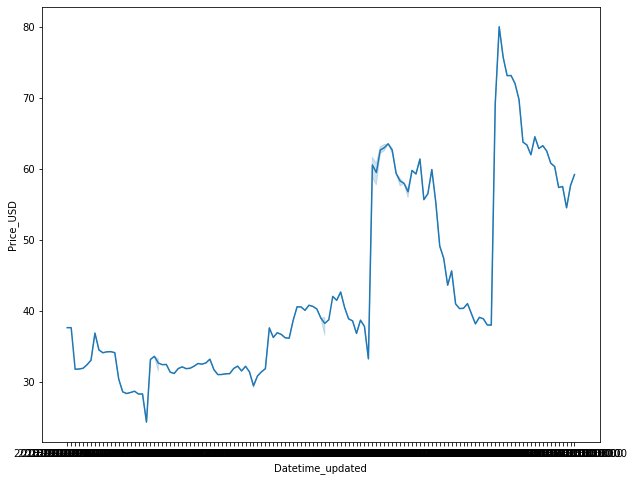

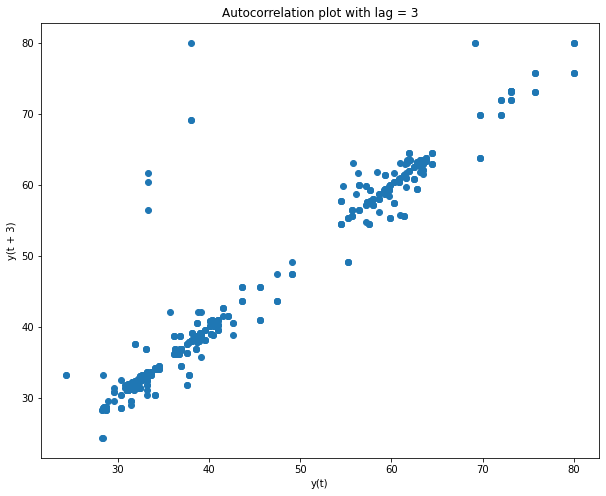

In [11]:
plot_nft_time_series(nft_name, nft_id)

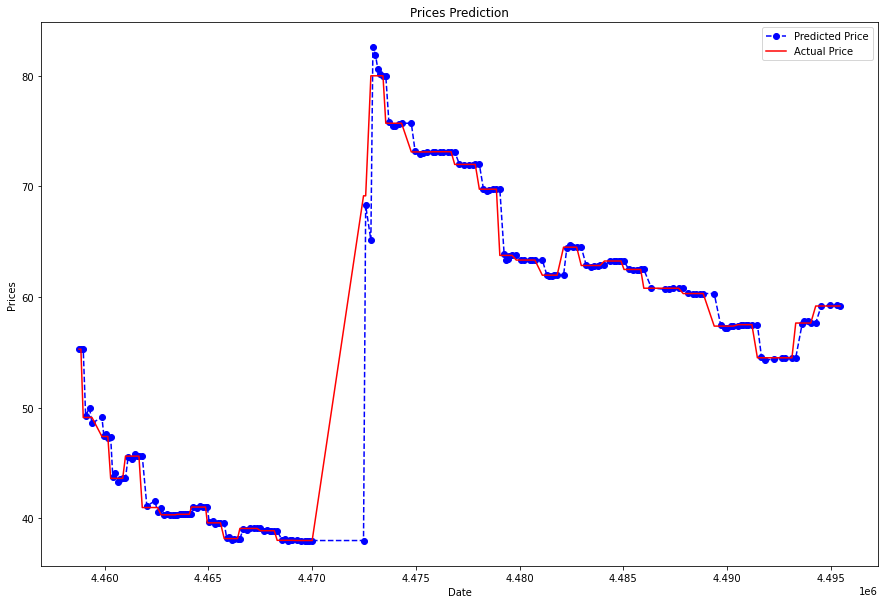

Predicted Price Change:  Positive
So, the price of the NFT will increase.

Accuracy:  0.53
Precision:  0.83
Recall:  0.59
F1-Score:  0.69

Predicted Price: $ 59.19
MSE Score:  6.99


In [12]:
calc_change_ARIMA(nft_name, nft_id, True)

## NFT Collection Predictions

In [13]:
def fetch_col_df(collection_name):
    nft_collection = df[df['Collection_cleaned'] == collection_name]
    results_df = nft_collection.groupby(pd.Grouper(key='Datetime_updated', axis=0)).mean()
    return results_df

In [14]:
def calc_collection_change_ARIMA(collection_name, details = True):
    sum_collection = fetch_col_df(collection_name)
    calc_ARIMA(sum_collection, details)

In [15]:
def plot_collection_time_series(collection_name):
    sum_collection = fetch_col_df(collection_name)
    plot_series(sum_collection)

In [16]:
collection_name = 'Godsunchained'

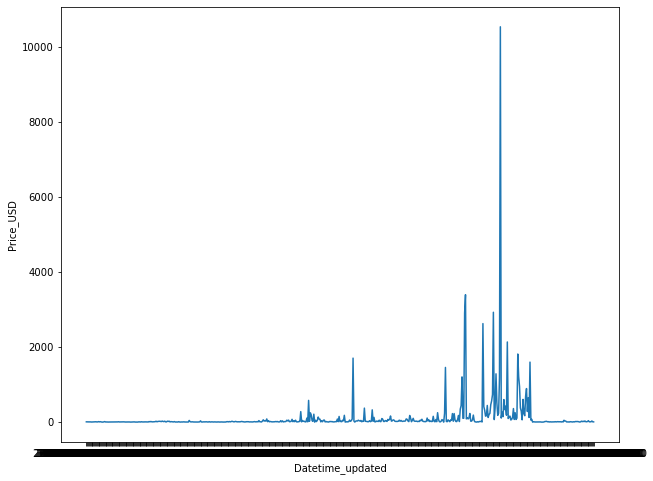

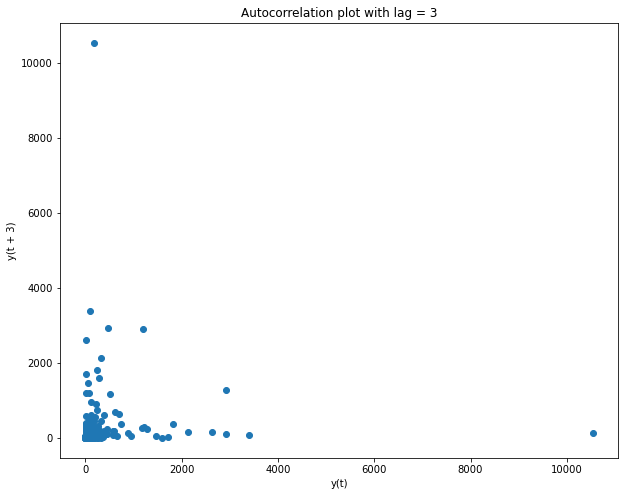

In [17]:
plot_collection_time_series(collection_name)

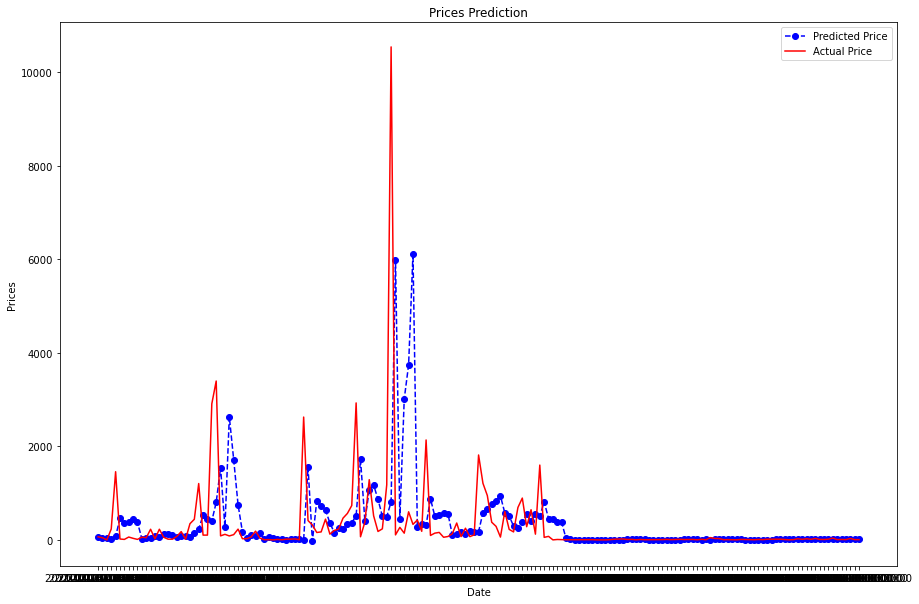

Predicted Price Change:  Positive
So, the price of the NFT will increase.

Accuracy:  0.68
Precision:  0.68
Recall:  0.73
F1-Score:  0.70

Predicted Price: $ 11.53
MSE Score:  1379


In [18]:
calc_collection_change_ARIMA(collection_name, True)